In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2
from PIL import Image
from torchsummary import summary
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('public/public.csv')
folderClasses = ['non_globally_sclerotic_glomeruli', 'globally_sclerotic_glomeruli']
df['path'] = df.apply(lambda x: f"public/{folderClasses[x['ground truth']]}/{x['name']}", axis=1)
df.head()

,name,ground truth,path
0,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
1,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
2,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
3,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
4,S-2006-005094_PAS_1of2_64552732435c92704a3d37d...,0,public/non_globally_sclerotic_glomeruli/S-2006...


In [3]:
def train_validate_test_split(df, split = 0.8, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    split_end = int(split * m)
    train = df.iloc[perm[:split_end]]
    validate = df.iloc[perm[split_end:]]
    train.reset_index(inplace=True)
    train.drop('index', axis=1, inplace=True)
    validate.reset_index(inplace=True)
    validate.drop('index', axis=1, inplace=True)
    return train, validate

train, validate = train_validate_test_split(df, seed=42)

C:\Users\tatke\AppData\Local\Temp\ipykernel_27224\273737700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('index', axis=1, inplace=True)
C:\Users\tatke\AppData\Local\Temp\ipykernel_27224\273737700.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate.drop('index', axis=1, inplace=True)


In [4]:
print(f"Train size: {len(train)}")
print(f"Validate size: {len(validate)}")

Train size: 4606
Validate size: 1152


In [5]:
sizes = None
for path in df['path']:
    img = np.asarray(plt.imread(path))
    if sizes is None:
        sizes = [img.shape]
    else:
        sizes.append(img.shape)

widths = [w for h, w, c in sizes]
heights = [h for h, w, c in sizes]

mean_width = round(np.mean(widths))
mean_height = round(np.mean(heights))

In [6]:
class GlomeruliDataset(Dataset):
    folderClasses = ['non_globally_sclerotic_glomeruli', 'globally_sclerotic_glomeruli']
    def __init__(self, df, transform=None):
        self.df = df
        self.labels = df['ground truth'].to_numpy().astype(np.int32)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.labels[idx]
        path = self.df.iloc[idx, 2]
        image = np.asarray(Image.open(path))

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((mean_width, mean_height)),
    v2.Normalize(mean = [0.5 for _ in range(4)], std = [0.5 for _ in range(4)]),
    v2.ToTensor(),
])

train_dataset = GlomeruliDataset(train, transform=transforms)
validate_dataset = GlomeruliDataset(validate, transform=transforms)

c:\Users\tatke\Projects\CMIL\env\cmil\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
print(device)

cuda


In [9]:
labels = train_dataset.labels
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
class_weight = 100. / class_sample_count
weights = np.array([class_weight[t] for t in labels])
weights = torch.from_numpy(weights)

In [10]:
sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, sampler=sampler, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(32 * 21 * 21, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [12]:
model = SimpleCNN().to(device)
summary(model, (4, mean_width, mean_height))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 354, 365]           1,616
       BatchNorm2d-2         [-1, 16, 354, 365]              32
              ReLU-3         [-1, 16, 354, 365]               0
         AvgPool2d-4         [-1, 16, 177, 182]               0
            Conv2d-5           [-1, 32, 88, 90]           4,640
       BatchNorm2d-6           [-1, 32, 88, 90]              64
              ReLU-7           [-1, 32, 88, 90]               0
         AvgPool2d-8           [-1, 32, 44, 45]               0
            Conv2d-9           [-1, 32, 42, 43]           9,248
      BatchNorm2d-10           [-1, 32, 42, 43]              64
             ReLU-11           [-1, 32, 42, 43]               0
        AvgPool2d-12           [-1, 32, 21, 21]               0
          Flatten-13                [-1, 14112]               0
           Linear-14                  [

In [13]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1], dtype=torch.float64))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
def train(epoch, model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images, labels = images.float().to(device), labels.float().to(device)
        
        outputs = model(images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.round(F.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(loader)
    accuracy = correct / total * 100
    print(f"Train Epoch {epoch}: Loss {running_loss:.3f},\t Accuracy: {accuracy:.2f}%")
    return running_loss, accuracy

In [15]:
@torch.no_grad()
def validate(epoch, model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    conf_matrix = np.zeros((2, 2))

    for i, (images, labels) in enumerate(loader):
        images, labels = images.float().to(device), labels.float().to(device)
        outputs = model(images)
        outputs.squeeze_()
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        predicted = torch.round(F.sigmoid(outputs))
        conf_matrix = conf_matrix + confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), labels=[0, 1])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    running_loss /= len(loader)
    accuracy = correct / total * 100
    print(f"Validation Epoch {epoch}: Loss {running_loss:.3f},\t Accuracy: {accuracy:.2f}%")
    return conf_matrix

In [16]:
torch.cuda.empty_cache()
train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train(epoch, model, train_loader, criterion, optimizer)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
confusionMatrix = validate(None, model, validate_loader, criterion)

c:\Users\tatke\Projects\CMIL\env\cmil\lib\site-packages\torchvision\transforms\functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Train Epoch 0: Loss 0.077,	 Accuracy: 86.97%
Train Epoch 1: Loss 0.046,	 Accuracy: 90.82%
Train Epoch 2: Loss 0.035,	 Accuracy: 93.68%
Train Epoch 3: Loss 0.028,	 Accuracy: 96.01%
Train Epoch 4: Loss 0.016,	 Accuracy: 97.33%
Validation Epoch None: Loss 0.039,	 Accuracy: 96.61%


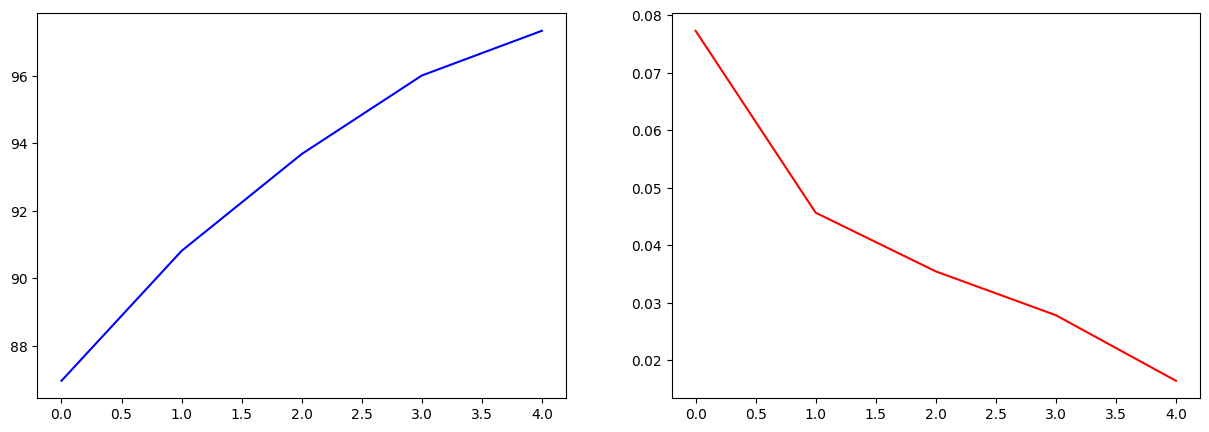

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accuracies, label='Train Accuracy', color='blue')
ax[1].plot(train_losses, label='Train Loss', color='red')
plt.show()

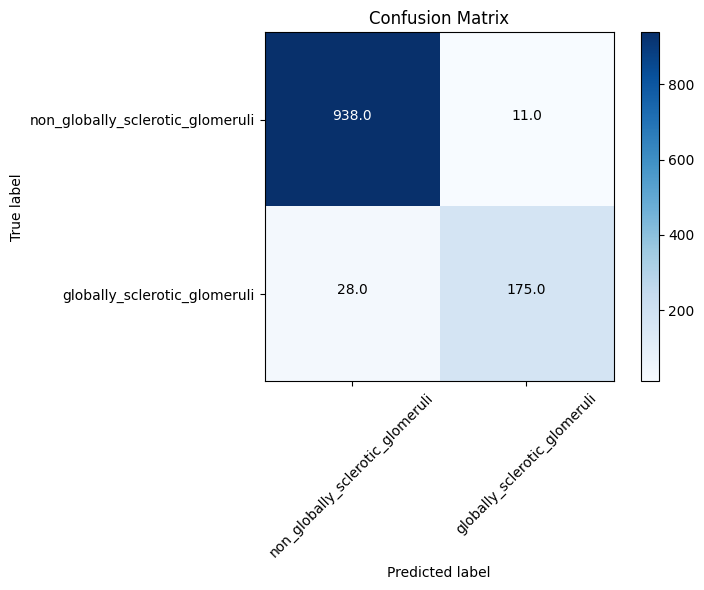

: 

In [21]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(confusionMatrix, folderClasses)